In [1]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import threading
import cv2
import os
import pandas as pd
import time 
import numpy as np
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector

# importing the modules
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
detector = MtcnnDetector()


In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available ()

1.12.1


True

In [3]:
data_csv = pd.read_csv("../train/label.csv")

In [ ]:
data_csv.head()


In [ ]:
print(data_csv["fname"])

In [9]:
len_of_lst = 160
shape_lst_image = (len_of_lst, 224, 224,3)
shape_image = (224, 224,3)
shape_facial = (len_of_lst,10)
range = shape_image[0] *shape_image[1]*shape_image[2]
print(shape_lst_image)

(160, 224, 224, 3)


In [3]:
def draw_facial(img, face):
    # Center coordinates
    face = np.array(face,dtype=np.uint8)
    x1 = [(face[0],face[5]),(face[1],face[6]),(face[2],face[7]),(face[8],face[7]),(face[4],face[9])]
    # x1 = face.reshape(5,2)
    # Radius of circle
    radius = 3
    # Red color in BGR
    color = (0, 0, 255)

    thickness = -1
    # Using cv2.circle() method
    # Draw a circle of red color of thickness -1 px
    for x in x1:
        img = cv2.circle(img, x, radius, color, thickness)
    return img


In [4]:
def mask_detect(image):
    (h,w) = image.shape[:2]
    boxes, facial5points = detector.detect_faces(image)
    # print(facial5points)
    # print(type(facial5points))
    # print(facial5points.shape)
    
    face = np.zeros(shape =shape_image)
    point_facial =np.zeros(shape =(10))
    is_face = False
    if(len(boxes)!=0):
        point_facial = facial5points[0]
        is_face = True
        # for box in boxes:
        box = boxes[0]
        (startX,startY,endX,endY)=box[:4].astype('int')
        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        c=cv2.resize(image[startY:endY, startX:endX],(shape_image[0],shape_image[1]))
        face = c
        color = (255,0,0)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        image = draw_facial(image,point_facial)
    return image, face,point_facial, is_face

In [5]:

def get_sim_matrix(lst_img):
    lst_reshape = lst_img.reshape(len_of_lst,range)
    list_sim = cosine_similarity(lst_reshape, lst_reshape)
    return list_sim

In [21]:
def PlayCamera(id):    
    num_of_face = 0
    num_of_face_not_null = 0
    video_capture = cv2.VideoCapture(id)
    face =  np.zeros(shape =shape_image)
    point_facial = np.zeros(shape =(10))
    is_face = False
    width  = int(video_capture.get(3))
    height = int(video_capture.get(4))
    if height > width:
        scale = height / width
    else:
        scale = width / height
    if width == height:
        scale = 2
    while height>1000 or width>1000: 
        height = int(height/scale)
        width = int(width/scale)

    list_face = np.zeros(shape = shape_lst_image, dtype=np.uint8)
    list_face_not_null = np.zeros(shape = shape_lst_image, dtype=np.uint8)
    list_face_point = np.zeros(shape = shape_facial, dtype=np.uint8)
    list_face_point_not_null = np.zeros(shape = shape_facial, dtype=np.uint8)
    while True:
        
        ret, frame = video_capture.read()
        
        if ret == True:
            frame = cv2.resize(frame,(width,height))
            try:
                img, face, point_facial,is_face = mask_detect(frame)
            except:
                pass
            if(len_of_lst>num_of_face):
                list_face[num_of_face] = face
                list_face_point[num_of_face] = point_facial
                if(is_face):
                    list_face_not_null[num_of_face_not_null] = face
                    list_face_point_not_null[num_of_face_not_null]
                    num_of_face_not_null +=1
                num_of_face +=1      
            cv2.imshow("img",frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                # video_capture.release()
                # cv2.destroyAllWindows()
                break
        else:
            break
            
    video_capture.release()
    cv2.destroyAllWindows()
    return list_face, list_face_not_null,list_face_point,list_face_point_not_null

In [9]:
name_dataset = "../train/videos/"


In [10]:
def get_embeded(data_csv):
    lst_out= []
    lst_out_notnull = []
    list_face_point = []
    list_face_point_notnull = []
    for name in data_csv["fname"]:
        scr = name_dataset + name
        x,x_notnull, y, y_notnull = PlayCamera(scr)
        sim_embed = get_sim_matrix(x)
        sim_embed_notnull = get_sim_matrix(x_notnull)
        lst_out.append(sim_embed)
        lst_out_notnull.append(sim_embed_notnull)
        list_face_point.append(y)
        list_face_point_notnull.append(y_notnull)
    data_csv["embed"] = lst_out
    data_csv["embed_notnull"] = lst_out_notnull
    data_csv["facial_point"] = list_face_point
    data_csv["facial_point_notnull"] = list_face_point_notnull
    return data_csv
data_out = get_embeded(data_csv)
data_out.to_csv("data_out.csv")


NameError: name 'data_csv' is not defined

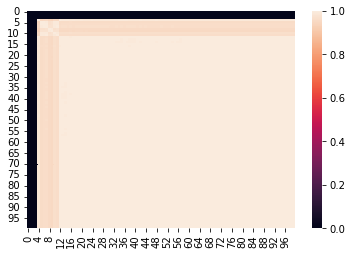

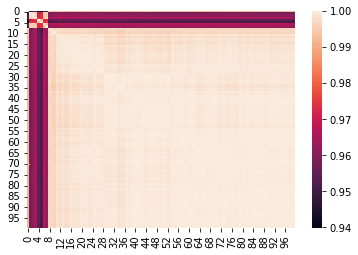

In [22]:
id = "../train/videos/313.mp4"
list_face, list_face_not_null, list_face_point,list_face_point_not_null = PlayCamera(id)
cv2.destroyAllWindows()
out = get_sim_matrix(list_face)
out_not_null = get_sim_matrix(list_face_not_null)
lst = [out,out_not_null]
for m in lst:
    hm = sn.heatmap(data = m[:100,:100])
    plt.show()

In [ ]:
image = np.zeros(shape = (720,360,3))
boxes, facial5points = detector.detect_faces(image)

In [20]:
print(list_face_point.shape)

(160, 10)


TypeError: list indices must be integers or slices, not NoneType

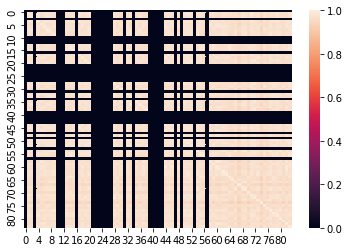

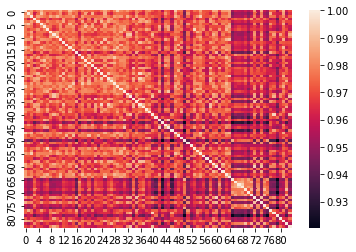

In [86]:
for m in lst:
    hm = sn.heatmap(data = m[:84,:84])
    plt.show()

In [11]:
id = "../train/videos/1.mp4"
list_face2, list_face_not_null2 = PlayCamera(id)
cv2.destroyAllWindows()
out2 = get_sim_matrix(list_face2)
out_not_null2 = get_sim_matrix(list_face_not_null2)
lst = [out2,out_not_null2]
for m in lst:
    hm = sn.heatmap(data = m[:100,:100])
    plt.show()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
hm = sn.heatmap(data = out[:100,:100])
plt.show()

In [17]:
print(lsst2.sum())

493691673


In [ ]:
id = "../train_avi/videos/36.mp4"
lsst1 = PlayCamera(id)
cv2.destroyAllWindows()
out2 = get_sim_matrix(lsst1)
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

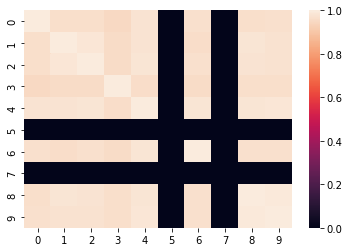

In [63]:
hm = sn.heatmap(data = out2[:10,:10])
plt.show()

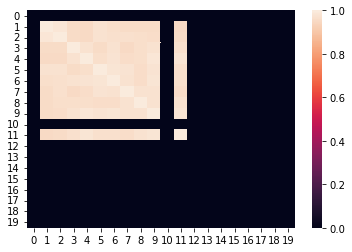

In [30]:
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

In [72]:
data_csv["test"] = None
data_csv.head()
# data_csv.dropna()

,fname,liveness_score,test
0,1.mp4,0,None
1,2.mp4,1,None
2,3.mp4,1,None
3,5.mp4,0,None
4,7.mp4,1,None


In [9]:
cv2.destroyAllWindows()

In [ ]:
id = "../train_avi/videos/36.mp4"

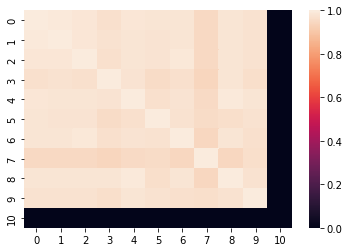

In [24]:
# rnet
hm = sn.heatmap(data = out2[:20,:20])
plt.show()

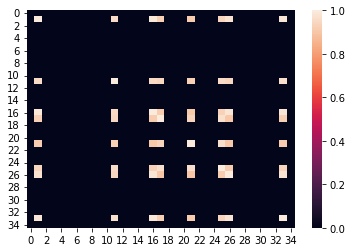

In [25]:
hm = sn.heatmap(data = out[:35,:35])
plt.show()

In [ ]:
lst_out = []
lst_out.append({
    "name":"test",
    "embed": out
})
data = pd.DataFrame(lst_out)

In [ ]:
x = data["embed"].values[0]
print(type(x))

In [ ]:
cv2.imshow("img",lsst[1])
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [39]:
cv2.destroyAllWindows()

In [ ]:
# video_capture.release()

In [ ]:
# id = "../train/videos/1.mp4"
# video_capture = cv2.VideoCapture(id)
# num = 0
# while True:
    
#     ret, frame = video_capture.read()
#     num += 1
#     img, face = mask_detect(frame)

#     cv2.imshow('{}'.format(id), img)        
#     if cv2.waitKey(1) & 0xFF == ord('q'):
        

#         break
    
# print(num)
# PlayCamera()

In [ ]:
#Convert to AVI
# import imageio
# src_dir = "../train/videos/"
# dest_dir = "../train_avi/videos/"
# lstmp4 = os.listdir(src_dir)

# for file in lstmp4:
#     scr = src_dir+file
    
#     des = dest_dir + file
    
#     reader = imageio.get_reader(scr)
#     fps = reader.get_meta_data()['fps']
#     writer = imageio.get_writer(des, fps=fps)

#     for im in reader:
#         writer.append_data(im[:, :, :])
#     writer.close()

In [ ]:
img1 = cv2.imread("Truyen_small.png")
img2 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img1,100,200)
img_zero = np.zeros(shape =(img1.shape[0],img1.shape[1],3))
# x = cosine_similarity(np.array([lsst[1].reshape(-1)]), np.array([lsst[59].reshape(-1)]))


In [ ]:
print(x)

In [ ]:
print(lst[0][0,1])
print(lsst[0,0,1])

In [ ]:
print(img1.shape)

In [ ]:
cv2.imshow("x",edges)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [18]:
test_set = "../public/videos"
lst = os.listdir(test_set)
data_test = pd.DataFrame()
data_test["fname"] = lst
data_test["liveness_score"] = 0
data_test.describe()
data_test.to_excel("public_test.xlsx")
data_test.to_csv("public_test.csv")